In [6]:
include("src/PyrochloreGeometry.jl")
import .PyrochloreGeometry as geom
import CSV
using StaticArrays
using LinearAlgebra
using BenchmarkTools
LinearAlgebra.BLAS.set_num_threads(1)

# Vec3_F64 = Union{SVector{Float64,3},Vector{Float64}}
# define static convenience types

const Vec3 = geom.Vec3;
const Vec3_F64 = geom.Vec3_F64;


In [2]:
L = 5
lat = geom.PyroFCC(L)

# check that these are correct
for (i, ss) in enumerate(lat.spin_sites)
    @assert i == geom.spin_idx(lat, ss)
end

for (i, ts) in enumerate(lat.tetra_sites)
    @assert i == geom.tetra_idx(lat, ts)
end

In [3]:
L = 2
lat = geom.PyroFCC(L)
# SVector{3,Float64}(0,0,0)

@benchmark geom.tetra_idx(lat, lat.tetra_sites[rand(1:8*L^3)])

BenchmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):  3.047 μs …  1.253 ms  ┊ GC (min … max): 0.00% … 98.77%
 Time  (median):     5.032 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.194 μs ± 12.495 μs  ┊ GC (mean ± σ):  2.38% ±  0.99%

                     ▃▁ ▇▁▁█▁▄▆▃▆▆▃▆▄▂▄▂▁▂                    
  ▂▂▂▂▁▂▃▂▃▃▃▄▄▄▆▄▇█▅██▇██████████████████████▇▆▆▅▄▅▄▄▄▃▃▃▃▃ ▅
  3.05 μs        Histogram: frequency by time        6.76 μs <

 Memory estimate: 560 bytes, allocs estimate: 17.

In [4]:
function load_A(filepath::String)
    file = CSV.File(filepath,ignorerepeated=true, delim=' ');
    
    L = Integer((length(file) / 16)^(1/3))
    
    # Index scheme: A site, sublat
    A = Array{Float64, 2}(undef, 4*L^3, 4)
    
    lat = geom.PyroFCC(L)
    
    for row in file
        psl = row.pyro_sl + 1 # convert to 1-based (PAIN)
        tetra_loc = @SVector[row.X,row.Y,row.Z] .- geom.pyro[psl]
        ti = geom.tetra_idx(lat, tetra_loc)
        A[ti, psl] = row.A
    end
    return A
end

load_A (generic function with 1 method)

In [143]:
A_dict = Dict(
    "0flux_big"=>load_A("/Users/alaricsanders/gh/QSI/data/a_finding/0_flux_big.gauge"),
    "0flux" => load_A("/Users/alaricsanders/gh/QSI/data/a_finding/0_flux_manual.gauge"),
    "πflux" => [ 0 0 π π ; 0 0 0 0; 0 0 π π; 0 0 0 0 ],
    "ππ00" =>  [ 0 0 0 π ; 0 0 0 0; 0 0 0 π; 0 0 0 0 ],
    "FF_even"=>load_A("../QSI/data/a_finding/FF_even.gauge")
    )

Dict{String, Matrix{Float64}} with 5 entries:
  "FF_even"   => [-0.939184 2.8251 -0.0982644 1.77518; -1.84161 -1.52392 1.3233…
  "ππ00"      => [0.0 0.0 0.0 3.14159; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 3.14159; 0.…
  "0flux_big" => [2.86353 -0.246715 1.00746 -2.35734; -2.70824 -1.01674 1.29788…
  "πflux"     => [0.0 0.0 3.14159 3.14159; 0.0 0.0 0.0 0.0; 0.0 0.0 3.14159 3.1…
  "0flux"     => [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.…

In [6]:

function calc_fluxes(lattice, A)
    @assert length(A) == length(lattice.spin_sites)
    
    Phi = ones(ComplexF64, length(lattice.A_sites), 4)
    hexa_sites = geom.get_hexagons(lattice)
    
    for (I, row) in enumerate(hexa_sites)
        for (nu, hex) in enumerate(row)
            for (i, (J, sl)) in enugeom.merate(hex)
                Phi[I,nu] *= exp(1im * A[J, sl] * (-1)^i )
            end
        end
    end
   
    return angle.(Phi)
end

calc_fluxes (generic function with 1 method)

In [ ]:
# genealised version



function calc_fluxes(lattice, A)
    @assert length(A) == length(lattice.spin_sites)
    
    Phi = ones(ComplexF64, length(lattice.A_sites), 4)
    hexa_sites = geom.get_hexagons(lattice)
    
    for (I, row) in enumerate(hexa_sites)
        for (nu, hex) in enumerate(row)
            for (i, (J, sl)) in enugeom.merate(hex)
                Phi[I,nu] *= exp(1im * A[J, sl] * (-1)^i )
            end
        end
    end
   
    return angle.(Phi)
end

In [7]:
lat = geom.PyroFCC(1)
calc_fluxes(lat, A_dict["ππ00"])

4×4 Matrix{Float64}:
 -3.14159  0.0   3.14159  0.0
  3.14159  0.0  -3.14159  0.0
 -3.14159  0.0   3.14159  0.0
  3.14159  0.0  -3.14159  0.0

# GMFT expansion
The Hamiltonian, without magnetic field, reads
$$
\begin{align}
H_{XYZ} =& \frac{J_{zz}}{2}\sum_{r_{\alpha}} Q_{r_{\alpha}}^{2} + \frac{J_{\pm}}{2}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} S^{+}_{r_\alpha,\mu}S^{-}_{r_{\alpha},\nu} + h.c.\\
&+J_{\pm\pm}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} S^+_{r_{\alpha},\mu}S^+_{r_{\alpha},\nu}+h.c.\\
% &+\sum_{\langle i j \rangle} \frac{J_\pm}{2} (\sigma_i^+\sigma_j^- + \sigma_i^-\sigma_j^+ )
&-\sum_{r_A, \mu} \frac{\boldsymbol{\hat{z}}_i \cdot \boldsymbol{B}}{2}
(S^+_{r_A,\mu} + S^-_{r_A,\mu}) 
\, . \nonumber
\end{align}
$$

After aplying the mapping
$$
\begin{align}
S^{+}_{r_{A},\mu} &= \frac{1}{2}\phi^{+}_{r_A}e^{iA_{r_{A},r_{A}+b_{\mu}}} \phi^-_{r_A+b_\mu}
\end{align}
$$

where $\phi$ is the spinon rotor creator/destroyer.

This generates the action
$$
\begin{align}
S_{GMFT} =& \int d\tau\sum_{x\in \rm Tetras} \frac{1}{2J_{zz}}\partial_{\tau}\phi^{*}_{x\tau}\partial_{\tau}\phi_{x \tau} + i \lambda_{x \tau}(\phi_{x \tau}^{*}\phi_{x \tau} -1) + H_{GMFT}
\\
H_{GMFT} =& + \frac{J_{\pm}}{8}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} \phi^{+}_{r_{\alpha}+\mu}\phi^{-}_{r_{\alpha}+\nu}e^{i\eta_x(A_{r,r+\nu}-A_{r,r+\mu})} \\
&+\frac{J_{\pm\pm}}{8}\sum_{r_{\alpha}}\sum_{\mu \neq \nu} \phi^+_{r_{\alpha}}\phi^+_{r_{\alpha}}\phi^-_{r_{\alpha}+\mu}\phi^-_{r_{\alpha}+\nu}e^{i\eta_x(A_{r,r+\nu}+A_{r,r+\mu})}+h.c.\\
&-\sum_{r_A, \mu} \frac{\boldsymbol{\hat{z}}_\mu \cdot \boldsymbol{B}}{4} \left[ \phi_{r_A}^+ e^{iA_{r_A, r_A+b_\mu} } \phi_{r_A + b_\mu}^-  + h.c.\right]
\end{align}
$$

(For now, drop the $J_{\pm\pm}$ term since it makes life harder)

In [8]:
@inline function calc_nn_hopping(lat::geom.PyroFCC, K::Vec3_F64, A::Matrix{Float64}, B::Union{Vector{Float64},Vec3_F64})
    #=
    Calculates the nearest-neighbour hopping matrix elements due to applied magnetic field.
    =#
    # Project B onto the four local z axes
    Bs = map(e-> e[:,3]' * B, geom.axis)
    H = zeros(ComplexF64, length(lat.tetra_sites), length(lat.tetra_sites))
    
    @assert size(A)[1] == length(lat.A_sites)
    # the nearst neighbour (magnetic) hoppings
    for (J0, x0) in enumerate(lat.A_sites)
        for mu = 1:4
            x1 = x0 + 2*geom.pyro[mu]
            J1 = geom.tetra_idx(lat, x1)

            hh = Bs[mu]/4 * exp(1.0im*A[J0,mu] - 1.0im*K'*(x1-x0) )
            H[J0, J1] += hh
            H[J1, J0] += conj(hh)
        end
    end
    
    return H
end

calc_nn_hopping (generic function with 1 method)

In [9]:
kk = @SVector [1.,1.,1.]
@benchmark calc_nn_hopping(lat, kk,A_dict["0flux"], [0.,1.,1.])


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  55.083 μs …  4.462 ms  ┊ GC (min … max): 0.00% … 98.13%
 Time  (median):     55.833 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   57.950 μs ± 73.155 μs  ┊ GC (mean ± σ):  2.69% ±  2.17%

  ▄▇██▇▅▄▃▄▃▃▂▁▂▂▃▂▂▁                                         ▂
  ███████████████████████▇▇▇▆▆▆▅▇▆▅▅▅▅▅▄▅▅▄▄▅▄▄▄▄▄▄▅▄▃▁▄▃▃▅▁▅ █
  55.1 μs      Histogram: log(frequency) by time      68.1 μs <

 Memory estimate: 22.41 KiB, allocs estimate: 717.

In [10]:
@inline function calc_xxz_hopping(lat::geom.PyroFCC, K::Vec3_F64, A::Matrix{Float64})
    #=
    Calculates the next-neighbour hoppings due to the XXZ like $S^+S^-$ terms, with Jpm = 1.
    =#

    H = zeros(ComplexF64, length(lat.tetra_sites), length(lat.tetra_sites))
    for (J0, x0) in enumerate(lat.A_sites)
        # the A sites
        for mu = 1:4
            x1 = x0 + 2*geom.pyro[mu]
            J1 = geom.tetra_idx(lat, x1)
                
            for nu = [1:mu-1; mu+1:4]
                
                x2 = x0 + 2*geom.pyro[nu]
                J2 = geom.tetra_idx(lat, x2)

                H[J1, J2] += 1/4*exp(1.0im*(A[J0,mu] - A[J0,nu]) - 1.0im*K'*(x1-x2))
                @assert mu != nu
            end
        end

        # the B sites
        x0 += [2,2,2]
        J0 += length(lat.A_sites)
        # @assert J0 == tetra_idx(lat, x0) 
        for mu = 1:4
            x1 = x0 - 2*geom.pyro[mu]
            J1 = geom.tetra_idx(lat, x1)
                
            for nu = [1:mu-1; mu+1:4]
                x2 = x0 - 2*geom.pyro[nu]
                J2 = geom.tetra_idx(lat, x2)
                H[J1, J2] += 1/4*exp(1.0im*(-A[J1,mu] + A[J2,nu]) - 1.0im*K'*(x1-x2))
            end
        end
        
    end

    return H
end
    

calc_xxz_hopping (generic function with 1 method)

In [11]:
@inline function calc_xxz_hopping_fast(lat::geom.PyroFCC, K::Vec3_F64, A::Matrix{Float64})
    #=
    Calculates the next-neighbour hoppings due to the XXZ like $S^+S^-$ terms, with Jpm = 1.
    =#

    H = zeros(ComplexF64, length(lat.tetra_sites), length(lat.tetra_sites))
    for (J0, x0) in enumerate(lat.A_sites)
        # the A sites
        for mu = 1:4
            x1 = x0 + 2*geom.pyro[mu]
            J1 = geom.tetra_idx(lat, x1)
                
            for nu = (mu+1):4
                x2 = x0 + 2*geom.pyro[nu]
                J2 = geom.tetra_idx(lat, x2)

                z = 1/4*exp(1.0im*(A[J0,mu] - A[J0,nu]) - 1.0im*K'*(x1-x2))
                H[J1, J2] += z
                H[J2, J1] += conj(z)
            end
        end

        # the B sites
        x0 += [2,2,2]
        J0 += length(lat.A_sites)
        # @assert J0 == tetra_idx(lat, x0) 
        for mu = 1:4
            x1 = x0 - 2*geom.pyro[mu]
            J1 = geom.tetra_idx(lat, x1)
                
            for nu = mu+1:4
                x2 = x0 - 2*geom.pyro[nu]
                J2 = geom.tetra_idx(lat, x2)
                z= 1/4*exp(1.0im*(-A[J1,mu] + A[J2,nu]) - 1.0im*K'*(x1-x2))
                H[J1, J2] += z
                H[J2, J1] += conj(z)
            end
        end
        
    end

    return H
end

for j in 1:1000
lat = geom.PyroFCC(1)
aa = rand(Float64,(4,4))
kk = @SVector rand(Float64, 3)
    
@assert norm(calc_xxz_hopping(lat, kk, aa) - calc_xxz_hopping_fast(lat, kk, aa)) < 1e-10
end

In [12]:

@benchmark calc_xxz_hopping_fast(lat, kk, A_dict["0flux"])


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  249.458 μs …  2.419 ms  ┊ GC (min … max): 0.00% … 88.12%
 Time  (median):     254.458 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   259.532 μs ± 93.959 μs  ┊ GC (mean ± σ):  1.59% ±  3.93%

  ▂▆▇██▅▄▅▆▇█▆▄▄▅▄▂▂▁▁▁                                        ▃
  ███████████████████████████▇████▇▇▇▇██▇▇▇▆▇▇▇▅▇▆▅▆▆▆▅▄▄▅▃▅▄▅ █
  249 μs        Histogram: log(frequency) by time       286 μs <

 Memory estimate: 89.00 KiB, allocs estimate: 2957.

In [13]:

function diagonalise_M(k, A::Matrix{Float64}, Jpm = -1., B = [0.,0.,0.])
    #=
    Calculates the spinon hopping matrix and diagonalises it.
    - K is a list of k-space points, e.g. [k1, k2, k3, ... kM]
    - A is a [num_tetra/2, 4] matrix of gauge connections, interpreted as running out of the $A$ sites.
    - Jpm is the XXZ coupling
    - B is the magnetic field in global cubic coords

    Returns:
    - eps, a [M, num_tetra] list of sorted energies
    - U,   a [M, num_tetra, num_tetra] list of eigenvectors such that H[J] @ U[J] =  U[J] @ diag(eps[J])
    =#
    K = SVector{3,Float64}(k)

    Jpm = convert(Float64, Jpm)
    B   = convert(Vec3_F64, B)
    
    # infer the lattice size from A
    lat = geom.PyroFCC( round(Int, (size(A)[1]/4)^(1/3)) )
    @assert length(lat.spin_sites) == length(A)
    
    H = Jpm*calc_xxz_hopping_fast(lat, K, A) + calc_nn_hopping(lat, K, A, B)

    @assert norm(H - H') < 1e-10
    
    eps, U = eigen!(Hermitian(H))
    
    
    return eps, U
end

diagonalise_M (generic function with 3 methods)

In [14]:
high_symmetry_points = Dict(
    "\\Gamma"=> [0.,0.,0.],
    "X"=> [1.,0.,0.],
    "W"=> [1.,0.5,0.],
    "K"=> [0.75,0.75,0.],
    "L"=> [0.5,0.5,0.5],
    "U"=> [1.0, 0.25,0.25]
) 

Dict{String, Vector{Float64}} with 6 entries:
  "U"       => [1.0, 0.25, 0.25]
  "W"       => [1.0, 0.5, 0.0]
  "X"       => [1.0, 0.0, 0.0]
  "\\Gamma" => [0.0, 0.0, 0.0]
  "L"       => [0.5, 0.5, 0.5]
  "K"       => [0.75, 0.75, 0.0]

In [15]:
function lerp(x0, x1, step)
    d = norm(x0-x1)
    T = reverse(range(start=1,stop=0, step=-step/d))
    return T*d, map( t-> t*(x1-x0) + x0, T)
end

lerp([1,0,0],[0,1,0],0.1)

(0.014213562373095064:0.1:1.4142135623730951, [[0.9899494936611666, 0.01005050633883342, 0.0], [0.9192388155425117, 0.08076118445748826, 0.0], [0.848528137423857, 0.15147186257614298, 0.0], [0.7778174593052023, 0.2221825406947977, 0.0], [0.7071067811865475, 0.29289321881345254, 0.0], [0.6363961030678927, 0.36360389693210726, 0.0], [0.565685424949238, 0.434314575050762, 0.0], [0.4949747468305833, 0.5050252531694167, 0.0], [0.42426406871192857, 0.5757359312880714, 0.0], [0.35355339059327373, 0.6464466094067263, 0.0], [0.282842712474619, 0.717157287525381, 0.0], [0.21213203435596428, 0.7878679656440357, 0.0], [0.14142135623730945, 0.8585786437626906, 0.0], [0.07071067811865472, 0.9292893218813453, 0.0], [0.0, 1.0, 0.0]])

In [16]:
function generate_path(point_dict, pathspec, points_per_unit=20)
    #=
    point_dict: A dictionary of the form 'label': [a,b,c]
    pathspec: A list of point labels, e.g. ["\\Gamma", "X", "M", ..., "X"]
    points_per_unit: how densely to make t vectors.

    Returns: tuple,
      t: a 'time' variable
      K: a N*(dim) vector of the lerp'd K points
      t_ticks: the time coordinates for the path points
    =#
    if length(pathspec) == 0
        print("Path has length zero, exiting")
        return [], [], []
    end

    
    
    t_ticks = [0.0]
    T = [0.0]
    p0 = point_dict[pathspec[1]]
    K = [p0]
    step = 1/points_per_unit
    
    for label in pathspec[2:length(pathspec)]
        p = point_dict[label]
        tau, K_loc = lerp(p0, p, step)
        append!(T, collect(tau).+last(T))
        push!(t_ticks, last(T) )
        append!(K, K_loc)
        
        p0 = p
    end

    return T, K, t_ticks
end
    


generate_path (generic function with 2 methods)

## Self-Consistency

Each indivitual rotor has unit length. We enforce the local constraint $\phi_{x \tau}^{*}\phi_{x \tau} = 1~ \forall x\in\{\text{Tetras}\}$ with the Lagrange multiplier
$$
\int d\tau \sum_{x \in \text{Tetras}} i \lambda_{x \tau}(\phi_{x \tau}^{*}\phi_{x \tau} -1)
$$
This is hard. Instead, we make a large-$N$ approximation that relaxes this to the soft constraint,
$$\frac{1}{N_{tetra}} \sum_{x \in \text{Tetras}} \phi_{x \tau}^{*}\phi_{x \tau} = 1,$$
enforced by
$$
\int d\tau \sum_{x \in \text{Tetras}} i \lambda(\phi_{x \tau}^{*}\phi_{x \tau} -1)
$$
revealing $\lambda$ to be a mass term. (look idk what the factor of i is doing but its prolly fine)

After some manipulations, one can show that we must choose $\lambda$ to satisfy
$$
1 =  \frac{1}{N_{tetra}N_{super}}\sum_\boldsymbol{k} \sum_{l} \frac{ J_{zz}}{\mathcal{E}_{l}(\boldsymbol{k})}
$$
where $N_{tetra}$ is the numberof tetrahedra in the enlarged unit cell, $N_{super}$ is the number of unit cells, and $\mathcal{E}_{l}(\boldsymbol{k})= \sqrt{2J_{zz}(\lambda+\epsilon_l(\boldsymbol{k}))}$.

Such equations probably don't have a closed-form solution. Work in units of $J_{zz}$, and optimise.

In [179]:
using Roots


function calc_lambda(bandf, nsample::Int=1000, kappa::Float64=1)
    K = rand(Float64, (nsample, 3) )*4π/8
    
    eps = reduce(vcat, map(k->bandf(k)[1],eachrow(K))')

    min_lam = -minimum(eps)
    bandwidth = maximum(eps) + min_lam

    max_lam = kappa^(-2) /2 - minimum(eps)
    
    function constr(λ)
        return mean( (eps .+ λ).^-0.5)/sqrt(2) - kappa
    end

    # function constr_p(λ)
    #     return mean( -0.5 *(eps .+ λ).^-1.5)/sqrt(2)
    # end
    # print(constr(min_lam), constr(max_lam))
    return find_zero(constr, (min_lam, max_lam),Bisection(), naive=true)
    
end

function calc_lambda(A::Matrix{Float64}, Jpm::Float64, B::Union{Vec3_F64,Vector{Float64}}, 
        nsample::Int=1000, kappa::Float64=1)
    bandf = k -> diagonalise_M(k, A, Jpm, B)
    return calc_lambda(bandf, nsample, kappa)
end

calc_lambda (generic function with 6 methods)

In [18]:
@benchmark calc_lambda( A_dict["0flux"], -0.15,[0.,0,0],1000,1.)


BenchmarkTools.Trial: 15 samples with 1 evaluation.
 Range (min … max):  344.179 ms … 355.412 ms  ┊ GC (min … max): 1.84% … 2.44%
 Time  (median):     348.726 ms               ┊ GC (median):    2.29%
 Time  (mean ± σ):   349.371 ms ±   3.310 ms  ┊ GC (mean ± σ):  2.20% ± 0.41%

  ▁     ▁      █  ▁ ▁   ▁ ▁   ▁    ▁    ▁  ▁     ▁        ▁   ▁  
  █▁▁▁▁▁█▁▁▁▁▁▁█▁▁█▁█▁▁▁█▁█▁▁▁█▁▁▁▁█▁▁▁▁█▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁█ ▁
  344 ms           Histogram: frequency by time          355 ms <

 Memory estimate: 158.62 MiB, allocs estimate: 3750855.

In [19]:
# call it in this way because the lambda determinatio nonly needs to be done once
function spinon_dispersion_v(kpath, A, Jpm, B)
    bandf = k-> diagonalise_M(k, A, Jpm, B)
    λ = calc_lambda(bandf, 10000, 1)
    res = bandf.(kpath.*2π/8)
    E = reduce(vcat, [ sqrt.(2*(r[1].+λ))' for r in res ])
    U = [ r[2] for r in res ]
    return E, U
end

function spinon_dispersion(k, A, Jpm, B, λ)
    ϵ, U = diagonalise_M(k, A, Jpm, B)    
    return sqrt.(2*(ϵ.+λ)), U
end

    

spinon_dispersion (generic function with 1 method)

In [180]:
struct SimulationParameters
    A::Matrix{Float64}
    Jpm::Float64
    B::Vec3_F64
    λ::Float64
    lat::geom.PyroFCC

    function SimulationParameters(A, Jpm, B, nsample=10000,  kappa=1.0)
        L = round(Int, (size(A)[1]/4)^(1/3))
        new(A, Jpm, B, calc_lambda(A, Jpm, B, nsample, kappa), geom.PyroFCC(L) )
    end
end

function spinon_dispersion(k::Union{Vec3_F64,Vector{Float64}}, sim::SimulationParameters)
    ϵ, U = diagonalise_M(k, sim.A, sim.Jpm, sim.B)    
    return sqrt.(2*(ϵ.+ sim.λ )), U
end
    
    

spinon_dispersion (generic function with 2 methods)

In [175]:
using Plots
using PythonPlot
matplotlib.rcParams["text.usetex"] = true

true

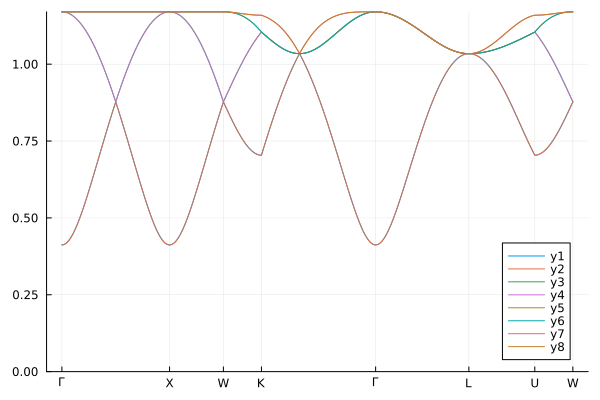

In [174]:
pfad = split("\\Gamma X W K \\Gamma L U W")

t, K, ticks = generate_path(high_symmetry_points, pfad, 128)


sim = SimulationParameters(A_dict["0flux"], -0.15, [0.0,0.0,0.0], 1000, 1.0)

E = reduce(vcat, map(k-> spinon_dispersion(k, sim)[1], K*2π/8)')

plot(t,E)
xticks!(ticks, pfad)
ylims!(0.,maximum(E))

In [181]:
# a vague idea of the density of states
@inline function gaussian(x,σ)
    local N = 1/√(2π)
    return N*exp(-0.5*(x/σ)^2)/σ
end

# function spectral_vibes(k, Egrid, sim, dE=0.2,nsample=2000)
#     Δ_vals = (1 .- 2 .* rand(Float64, (nsample, 3) ) )*4π/8
#     retval = zeros(size(Egrid))
#     # perform an MC integral
#     for Δ in eachrow(Δ_vals)
#         E1, _ = spinon_dispersion(k+Δ, sim)
#         E2, _ = spinon_dispersion(k-Δ, sim)
#         for e1 in E1, e2 in E2
#             retval += map(e-> gaussian(e - (e1+e2), dE), Egrid)
#         end
#     end
#     return retval
# end
    
    

gaussian (generic function with 1 method)

## Calculating the spectral weight

We now calculate
$$\begin{align}
\langle S^+(\mathbf{q}, t)S^-(\mathbf{-q},0)\rangle = 
&\frac{1}{4f^{2}N_{\rm spin }}\sum_{\begin{smallmatrix}\mathbf{k}&r_{A}&\mu\\ \mathbf{k}'&r_A'&\nu\end{smallmatrix}}
e^{iA_{r_A,r_A+b_\mu}-iA_{r_A',r_A'+b_\nu}}~e^{i \mathbf{k}\cdot \mathbf{b}_{\mu}-i \mathbf{k}'\cdot \mathbf{b}_{\nu}}
\times\left\langle 
\phi_{\mathbf{r}_{A}} ^{*}(\mathbf{k}+ \frac{\mathbf{q}}{2},t)\,
\phi_{\mathbf{r}_A+\mathbf{b}_\mu}(\mathbf{k}-\frac{\mathbf{q}}{2},t)~
\phi_{\mathbf{r}'_{A}+\mathbf{b}_\nu} ^{*}(\mathbf{k}'+ \frac{\mathbf{q}}{2},0)\,
\phi_{\mathbf{r}'_A}(\mathbf{k}'-\frac{\mathbf{q}}{2},0)
 \right\rangle
 \end{align}
$$
setting $K = \frac{1}{2}(k+k')$, $p=k-k'$, get
$$= \sum_{\mu,\nu} 
\left(\sum_{\mathbf{K}}\frac{1}{4f^2N_{\rm spin}} e^{i \mathbf{K}\cdot (b_\mu - b_\nu)}\right)
e^{iA_{r_A,r_A+b_\mu}-iA_{r_A',r_A'+b_\nu}}
\sum_{\mathbf{p},r_A,r'_A} 
 e^{i \mathbf{p}\cdot (b_\mu + b_\nu)/2}
\mathcal{G}_{r_A,r'_A}(\mathbf{p}+\mathbf{q}, t)\mathcal{G}_{r'_A+b_\nu,r_A+b_\mu}(-\mathbf{p}+\mathbf{q}, -t)
$$


The zero-temperature Green function, in terms of spinon energies $\mathcal{E}_l(\mathbf{k}) = \sqrt{2J_{zz}(\lambda+\epsilon_{l}(\mathbf{k}))}$
is
$$
\begin{align}
\mathcal{G}_{ab}(\mathbf{k},\omega) = \sum_{l=1}^{f}\frac{2J_{zz}U_{al} (\mathbf{k})U^{\dagger}_{lb}(\mathbf{k})}{-\omega^{2}+\mathcal{E}_l(\mathbf{k})^2}\\
= \sum_{l=1}^{f}{2J_{zz}U_{al} (\mathbf{k})U^{\dagger}_{lb}(\mathbf{k})}
\frac{1}{2\mathcal{E}_l(\mathbf{k})}
\left[ \frac{-1}{\omega-\mathcal{E}_l(\mathbf{k})} + \frac{1}{\omega+\mathcal{E}_l(\mathbf{k})} \right]
\end{align}
$$

Thus rendering the spin-spin response
$$
\begin{align*}
\mathcal{S}_{r_A\,\mu\;r_A'\,\nu}(\mathbf{q},\omega)=&
\sum_{\mathbf{\Delta}}\sum_{\begin{smallmatrix}r_{A}&\mu\\ r_A'&\nu\end{smallmatrix}}F_{\mu\nu}(\mathbf{\Delta})~
e^{iA_{r_A,r_A+b_\mu}-iA_{r_A',r_A'+b_\nu}}\,\times\\
&\int \frac{d\omega_{1}}{2\pi}\,
\mathcal{G}_{r_{A}\,r_{A}'}(\mathbf{\Delta}+\mathbf{q}, \omega_1)~
\mathcal{G}_{r_A+\mu\,r_A'+\nu}\,(-\mathbf{\Delta}+\mathbf{q},\omega_1-\omega)
\end{align*}
$$


In [118]:
# need both the Green fn itself and its residues

# function Green(k, ω, sim::SimulationParameters, tol=1e-10)
#     ϵ, U = diagonalise_M(k, sim.A, sim.Jpm, sim.B)
#     E2 = 2*(ϵ + sim.λ)
#     denom = -ω^2  + E2
#     assert( minimum(abs.( denom )) > tol, "Pole encountered in evaluation of Green function" )
#     return 2*U * diagm(1 ./ denom ) *U'
# end

# function Green_residue(k, E_idx, sim::SimulationParameters, tol=1e-10)
#     #=
#     Returns the residue of G(k,ω) at the pole  ω = +E_idx
#     Residue is negative of the same at         ω = -E_idx
#     =#
#     ϵ, U = diagonalise_M(k, sim.A, sim.Jpm, sim.B)
#     E2 = 2*(ϵ + sim.λ)
    
#     ω2 = E2[E_idx]
    
#     denom = (-ω2  + E2) 
#     # modify all singular values in denom
#     singular = abs.(denom) < tol
#     # let's just hope that the poles are simple
#     denom[singular] = -1 ./ (2*sqrt(E2[singular]))
    
#     return 2*U * diagm(1 ./ denom ) *U'
# end

function specweight_at(q, Δ, sim::SimulationParameters)
    E1, U1 = spinon_dispersion( Δ+q, sim)
    E2, U2 = spinon_dispersion(-Δ+q, sim)
    
    
    # the form factor
    W = (0.5+0im) .* [ 
        2 1 1 1; 
        1 2 1 1;
        1 1 2 1;
        1 1 1 2 
    ]

    for mu=1:4, nu=1:4
        # this is e^{i Δ • (b_mu + b_nu)/2 ), factoes of 2 cancel since pyro is 1/2 b
        W[mu,nu] *= exp(1im*Δ'* (geom.pyro[mu] + geom.pyro[nu])) 
    end

    local f=length(sim.lat.tetra_sites)
    S = zeros(f,f)
    for mu=1:4, nu=1:4
        for (jA, rA) in enumerate(sim.lat.A_sites), (jpA, rpA) in enumerate(sim.lat.A_sites)
            jB = geom.tetra_idx(sim.lat, rA + geom.pyro[mu])
            jpB = geom.tetra_idx(sim.lat, rpA + geom.pyro[nu])

            # the "l" bit
            x1 = U1[jA, :] .* conj(U1[jpA, :]) ./ (2*E1) 
            # the "l'" bit
            x2 = U2[jB, :] .* conj(U2[jpB, :]) ./ (2*E2) 
            
            S += W[mu,nu]*x1*x2'*exp(1im*(sim.A[jA,mu]-sim.A[jpA, nu]))
        end
    end
    E = reduce(hcat, [[e1 + e2 for e1 in E1] for e2 in E2])::Matrix{Float64}
    return E, S
end




function spectral_weight(q, Egrid, sim::SimulationParameters, nsample::Int=1000, grid_density::Int=1000)

    # cursed Monte Carlo integration
    num_flavours = div(length(sim.A),2)
    res = 0

    p_vals = π*rand((-grid_density,grid_density),nsample,3)/8/grid_density
    
    Sqω = zeros(ComplexF64,size(Egrid))
    # perform an MC integral
    dE = 3*(Egrid[2]-Egrid[1])

    bounds = [Inf, -Inf]
    
    for p in eachrow(p_vals)
        Enm, Snm = specweight_at(q, p, sim)
        Sqω += map(
            e-> sum( [S*gaussian(e - E, dE) for (E,S) in zip(Enm,Snm)]),
                Egrid)
        bounds[1] = min(bounds[1], reduce(min,  Enm) ) 
        bounds[2] = max(bounds[2], reduce(max,  Enm) )
    end
    return Sqω, bounds
end
        
    



spectral_weight (generic function with 3 methods)

In [155]:
using IJulia

pfad = split("\\Gamma X W K \\Gamma L U W")

t, K, ticks = generate_path(high_symmetry_points, pfad, 10)

# print(length(t))

sim = SimulationParameters(A_dict["FF_even"], 0.25, [0.2,0.2,0.2], 1000, 1.0)
Egrid = range(0,4,1000)


S = zeros(ComplexF64, length(K), length(Egrid))
lowerb = zeros(Float64, length(K))
upperb = zeros(Float64, length(K))

for (I, q) in enumerate(K*2π/8)
    IJulia.clear_output(true)    
    println(I,"/",length(K))
    S[I, :], (lowerb[I], upperb[I]) = spectral_weight(q, Egrid, sim, 100, 1000)
end


53/53


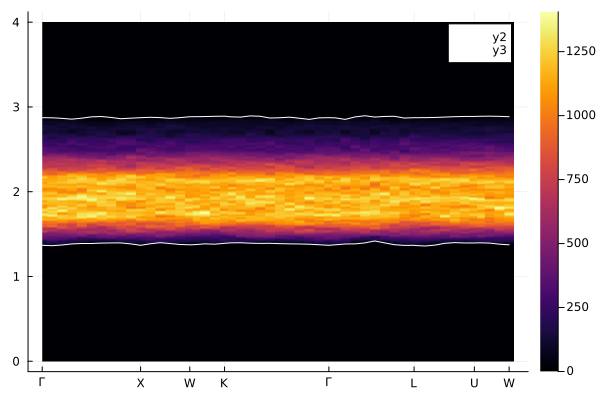

In [178]:
IJulia.clear_output(false)
heatmap(t,Egrid, real.(S)' )
plot!(t, lowerb, linecolor=:white)
plot!(t, upperb, linecolor=:white)
xticks!(ticks, pfad)
# ylims!(0.,maximum(E))

In [157]:
Plots.set_default_backend!(:pythonplot)
